### Named Entity Recognition with spacy

#### importing sqlite wikibooks dataset

In [8]:
import sqlite3
import pandas as pd

cnx = sqlite3.connect('../input/wikibooks-dataset/wikibooks.sqlite')
df_wikibooks = pd.read_sql_query("SELECT * FROM en", cnx)
df_wikibooks.head()

,title,url,abstract,body_text,body_html
0,Wikibooks: Radiation Oncology/NHL/CLL-SLL,https://en.wikibooks.org/wiki/Radiation_Oncolo...,Chronic Lymphocytic Leukemia and Small Lymphoc...,Front Page: Radiation Oncology | RTOG Trials |...,"<div class=""mw-parser-output""><table width=""10..."
1,Wikibooks: Romanian/Lesson 9,https://en.wikibooks.org/wiki/Romanian/Lesson_9,==Băuturi/Beverages==,Băuturi/Beverages[edit | edit source]\nTea : C...,"<div class=""mw-parser-output""><h2><span id=""B...."
2,Wikibooks: Karrigell,https://en.wikibooks.org/wiki/Karrigell,Karrigell is an open Source Python web framewo...,Karrigell is an open Source Python web framewo...,"<div class=""mw-parser-output""><p>Karrigell is ..."
3,Wikibooks: The Pyrogenesis Engine/0 A.D./GuiSe...,https://en.wikibooks.org/wiki/The_Pyrogenesis_...,====setupUnitPanel====,setupUnitPanel[edit | edit source]\nHelper fun...,"<div class=""mw-parser-output""><h4><span class=..."
4,Wikibooks: LMIs in Control/pages/Exterior Coni...,https://en.wikibooks.org/wiki/LMIs_in_Control/...,== The Concept ==,Contents\n\n1 The Concept\n2 The System\n3 The...,"<div class=""mw-parser-output""><div id=""toc"" cl..."


#### Reading an example from the dataset

In [9]:
import spacy

nlp = spacy.load("en_core_web_sm")
wiki_ex = df_wikibooks.iloc[17]['body_text']
doc = nlp(wiki_ex)
doc

As obvious from the term, this architecture works through a cycle of Sense, Plan and Act processes.

By sensing, it means getting the required information from the available sensors and converting it to some usable form.
Planning refers to the use of available information from sensing phase to determine the control parameters and sequences required for various components in order to make the robot proceed towards final goal.
Finally, act phase is simply the implementation of the processes and sequences underlined by the planning phase.
This kind of approach is useful if the sensing process is slow and the environment is quite static. For example, on a low speed processor, image processing may require lots of time to process each frame. Hence, it might not be feasible to process every frame and react to the gathered information in real-time. If we use this technique, the information will be processed at a very low frequency, providing more time for other real-time processes to run while

#### List of entities in the example

In [10]:
print('All entity types that spacy recognised from the document above')
set([ent.label_ for ent in doc.ents])

All entity types that spacy recognised from the document above


{'ORG'}

#### Listing person and organization entities of the example

In [11]:
print('Persons from the document above')
print(set([ent for ent in doc.ents if ent.label_ == 'PERSON']))
print('Organizations from the document above')
print(set([ent for ent in doc.ents if ent.label_ == 'ORG']))

Persons from the document above
set()
Organizations from the document above
{Sense, Plan and Act}


### Visualizing Named Entities

In [12]:
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

#### Importing libraries and reading datasets

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import AdamW, AutoTokenizer, AutoModelForTokenClassification, get_scheduler
import torch


nltk.download('punkt')

data_dir = '../input/entity-annotated-corpus'
df = pd.read_csv(f'{data_dir}/ner_dataset.csv',encoding='ISO-8859-1')
df['Sentence #'] = df['Sentence #'].ffill()
df_gr = df.groupby('Sentence #').agg(lambda x: list(x))
print(df_gr.shape)
df_gr.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
(47959, 3)


,Word,POS,Tag
Sentence #,,,
Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


#### Visualizing wordcloud for geographical entities

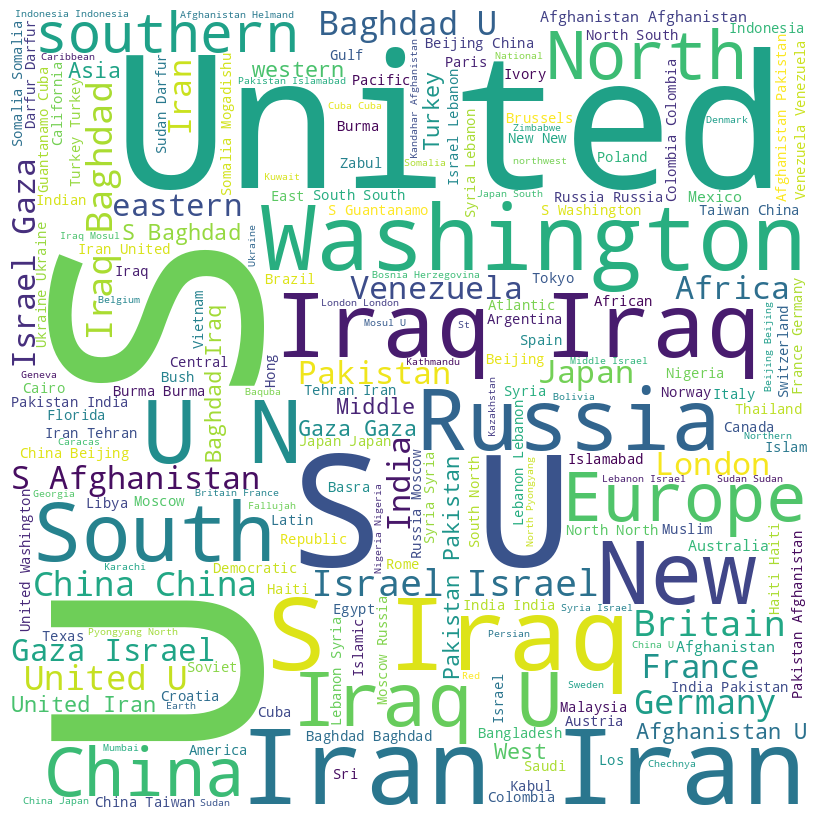

In [14]:
from wordcloud import WordCloud, STOPWORDS
geo_entities = ""
for word in df[df['Tag'] == 'B-geo']['Word'].tolist():
    geo_entities = geo_entities + " " + word
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(geo_entities)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Visualizing wordcloud for person entities

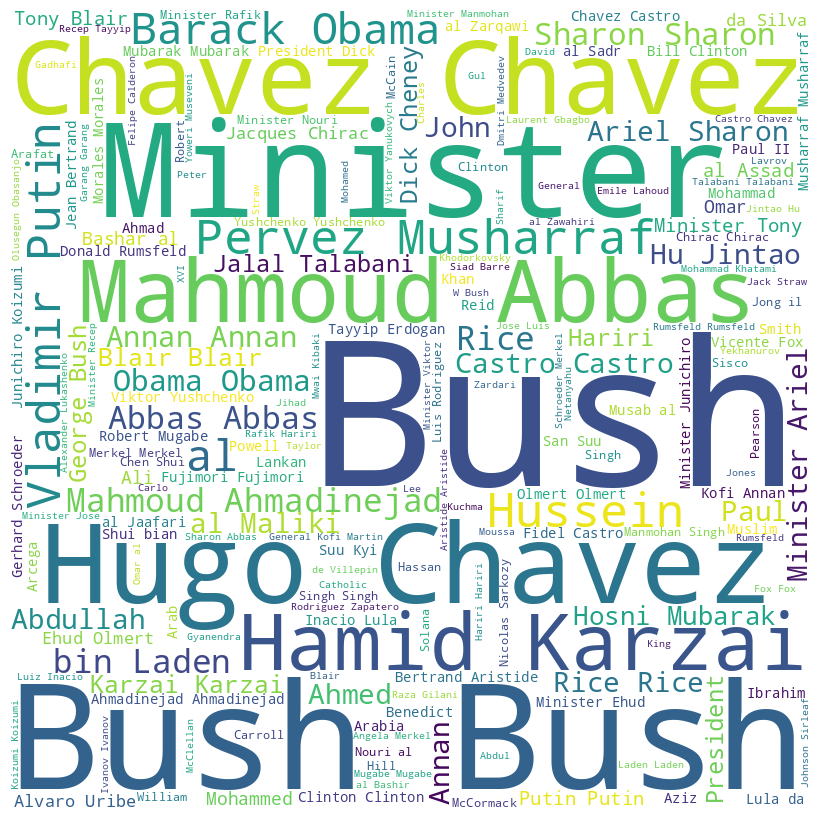

In [15]:
per_entities = ""
for word in df[df['Tag'] == 'I-per']['Word'].tolist():
    per_entities = per_entities + " " + word
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(per_entities)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Visualizing wordcloud for time entities

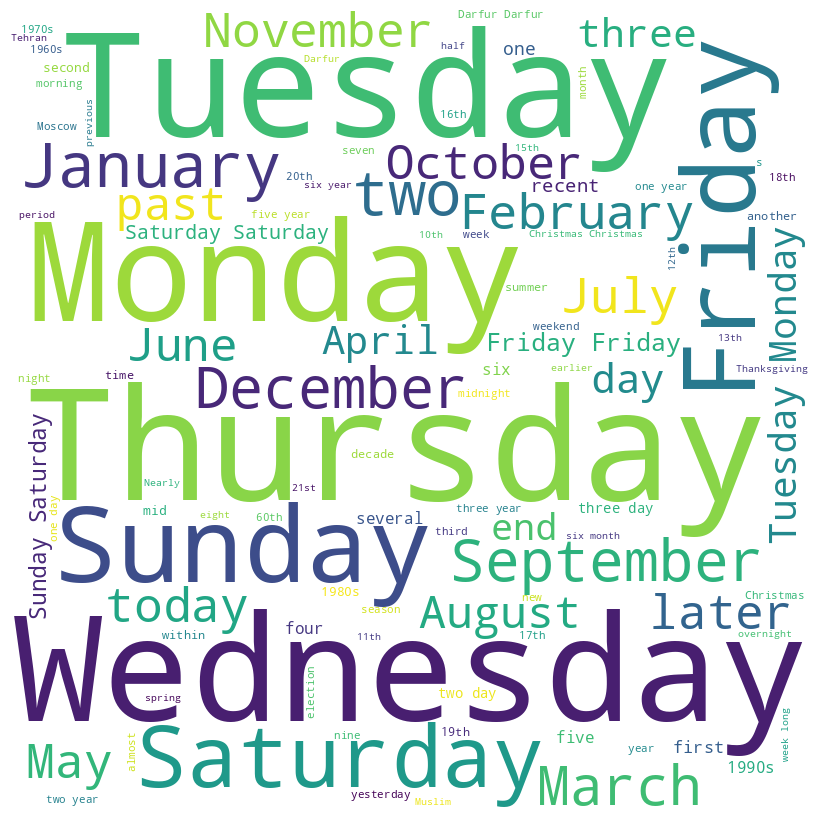

In [16]:
tim_entities = ""
for word in df[df['Tag'] == 'B-tim']['Word'].tolist():
    tim_entities = tim_entities + " " + word
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(tim_entities)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Visualizing wordcloud for gpe entities

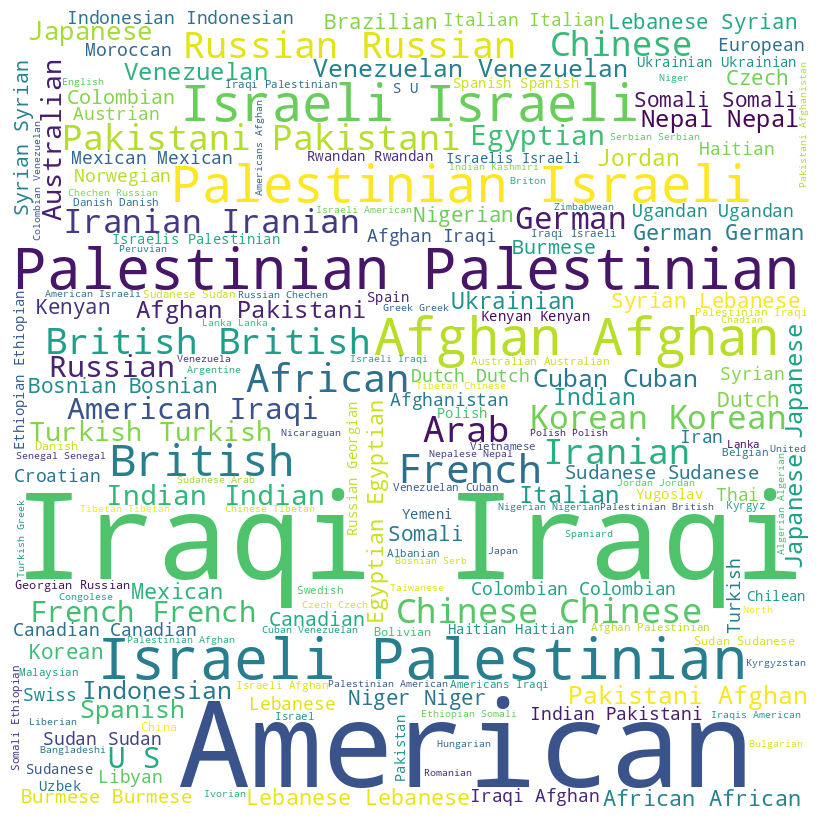

In [17]:
gpe_entities = ""
for word in df[df['Tag'] == 'B-gpe']['Word'].tolist():
    gpe_entities = gpe_entities + " " + word
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(gpe_entities)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#### Reading legal dataset

In [18]:
df_legal = pd.read_json("/kaggle/input/legal-ner/NER_TRAIN_JUDGEMENT.json")
df_legal.head()

,id,annotations,data,meta
0,90d9a97c7b7749ec8a4f460fda6f937e,"[{'result': [{'value': {'start': 90, 'end': 10...",{'text': ' (7) On specific query by the Bench...,{'source': 'tax_districtcourts judgement https...
1,a325c57ba5b84c6fa46bee65e6616633,"[{'result': [{'value': {'start': 26, 'end': 30...",{'text': 'He was also asked whether Agya <span...,{'source': 'criminal_punjab-haryana_high_court...
2,33cface31108441080976035ee04d07e,"[{'result': [{'value': {'start': 13, 'end': 25...","{'text': ' 5.2 CW3 Mr Vijay Mishra , Deputy M...",{'source': 'financial_districtcourts judgement...
3,08debe900b51464e9f26b5d1eecae170,[{'result': []}],{'text': 'You are hereby asked not to carry ou...,{'source': 'civil_bombay_high_court judgement ...
4,428070222cd940eba78b233829eb28b8,"[{'result': [{'value': {'start': 18, 'end': 43...",{'text': 'The pillion rider T.V. Satyanarayana...,{'source': 'motorvehicles_andhra_high_court ju...


#### Defining dataframe level preprocessing function for legal dataset

In [19]:
def preprocess_legal_ner(df):
    words = []
    tags = []
    annotations = df['annotations'].tolist()
    texts = df['data'].tolist()
    for i, text in enumerate(texts):
        annotation = annotations[i][0]['result']
        tmp_idx = 0
        word = []
        tag = []
        for ann in annotation:
            start = ann['value']['start']
            end = ann['value']['end']
            label = ann['value']['labels'][0]
            txt = ann['value']['text']
            prev = nltk.word_tokenize(text['text'][tmp_idx:start-1])
            word.extend(prev)
            tag.extend(['O'] * len(prev))
            word.append(txt)
            tag.append(label)
            tmp_idx = end + 1
        words.append(word)
        tags.append(tag)
    
    return words, tags

#### Applying preprocessing to legal dataset

In [20]:
words, tags = preprocess_legal_ner(df_legal)

In [21]:
dict_legal = {'Word': words, 'Tag': tags} 
df_legal_preprocessed = pd.DataFrame(dict_legal)

In [22]:
df_legal_preprocessed.head()

,Word,Tag
0,"[(, 7, ), On, specific, query, by, the, Bench,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[He, was, also, asked, whether, Agya, <, span,...","[O, O, O, O, O, OTHER_PERSON, O, O, O, O, O, O..."
2,"[5.2, CW3, Mr, Vijay Mishra, ,, Deputy, Manage...","[O, O, O, WITNESS, O, O, O, O, ORG, GPE, O, O,..."
3,[],[]
4,"[The, pillion, rider, T.V. Satyanarayana Murthy]","[O, O, O, OTHER_PERSON]"


#### In our case, we'll need columns `Word` (tokenized sentence) and `Tag` (entities in the sentence). Also, in order to fine-tune the model, we'll need to have the same entities as the model is trained on. Let's print entities from our data set and from the pretrained model.

In [23]:
tags = []
for tag in df_gr['Tag'].to_list():
    tags.extend(tag)
print('Entities in GMB dataset')
set(tags)

Entities in GMB dataset


{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [24]:
len(tags)

1048575

#### Plotting tag distribution for GMB dataset

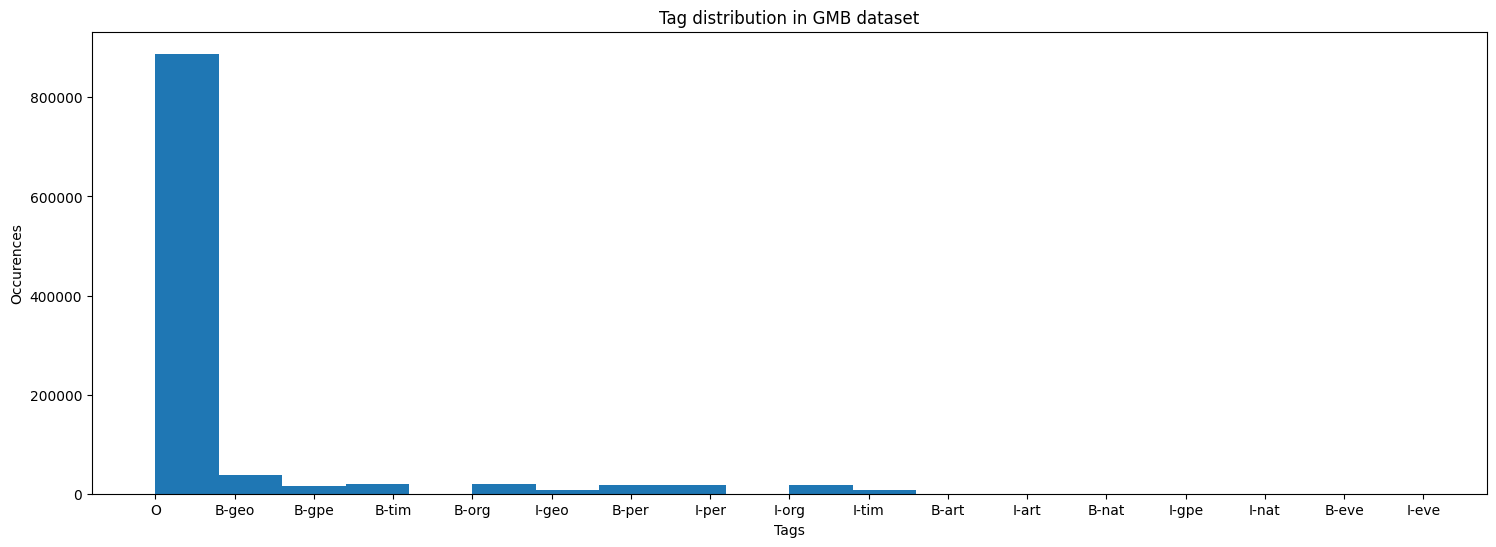

In [25]:
plt.figure(figsize=(18,6))
plt.title('Tag distribution in GMB dataset')
plt.hist(tags, bins=20)
plt.xlabel('Tags')
plt.ylabel('Occurences')
plt.savefig('gmb_dist.png')
plt.show()

#### Listing tags for legal dataset

In [26]:
tags = []
for tag in df_legal_preprocessed['Tag'].to_list():
    tags.extend(tag)
print('Entities in Legal-NER data set')
set(tags)

Entities in Legal-NER data set


{'CASE_NUMBER',
 'COURT',
 'DATE',
 'GPE',
 'JUDGE',
 'O',
 'ORG',
 'OTHER_PERSON',
 'PETITIONER',
 'PRECEDENT',
 'PROVISION',
 'RESPONDENT',
 'STATUTE',
 'WITNESS'}

In [27]:
len(tags)

176606

#### Plotting tag distribution for legal dataset

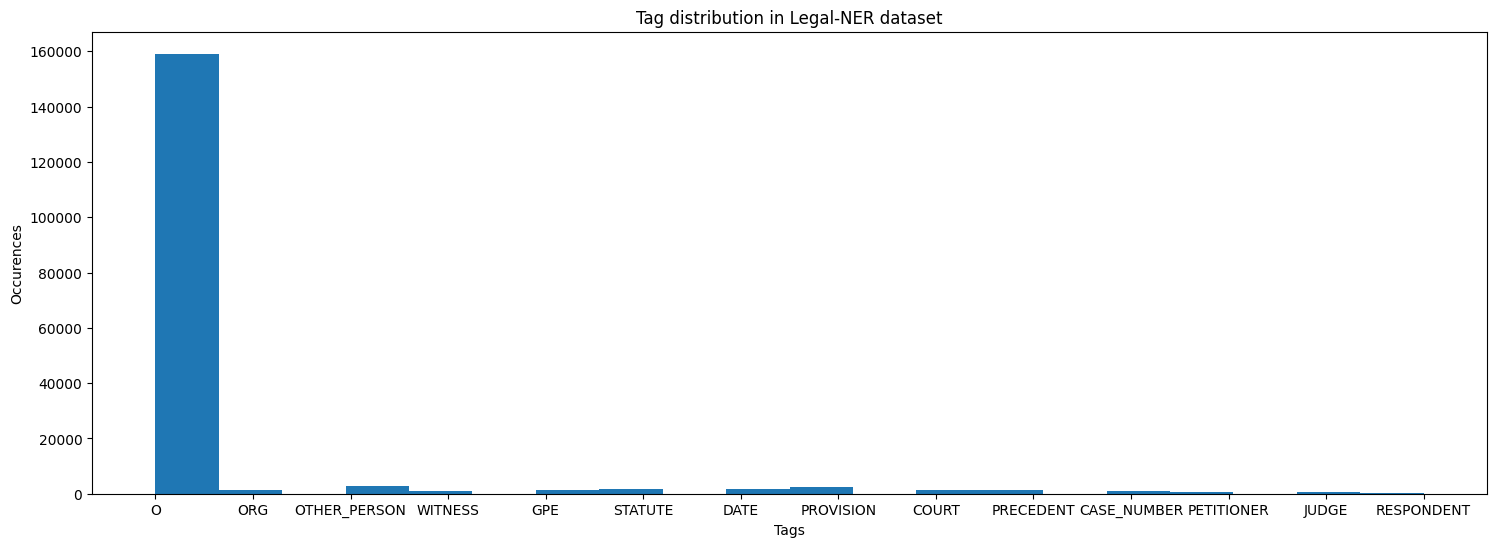

In [28]:
plt.figure(figsize=(18,6))
plt.title('Tag distribution in Legal-NER dataset')
plt.hist(tags, bins=20)
plt.xlabel('Tags')
plt.ylabel('Occurences')
plt.savefig('legal_ner_dist.png')
plt.show()

#### Defining entity mapping for GMB dataset to match bert-base-NER model

In [29]:
entity_mapping = {
'O':0,'B-per':3, 'I-per':4, 'B-org':5, 'I-org':6,'B-geo':7, 'I-geo':8,
'B-art':1, 'B-eve':1 , 'B-gpe':1, 'B-nat':1, 'B-tim':1,
'I-art':1, 'I-eve':1 , 'I-gpe':1, 'I-nat':1, 'I-tim':1,
}

#### Initializing bert-base-NER model to inspect pre-trained labels

In [30]:
MODEL_NAME = "dslim/bert-base-NER"
MAX_LEN = 128
#MODEL_NAME = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

print('Entities from the pretrained model')
model.config.id2label

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Entities from the pretrained model


{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

#### Defining entity mapping for legal dataset to match the model

In [31]:
legal_entity_mapping = {
    'O':0, 'CASE_NUMBER':1, 'COURT':5,
    'DATE':1, 'GPE':4, 'JUDGE':5,
    'ORG':5, 'OTHER_PERSON':3, 'PETITIONER':3,
    'PRECEDENT':1, 'PROVISION':1, 'RESPONDENT': 3,
    'STATUTE': 1, 'WITNESS':3
}

#### Defining dataset class
#### Create the mapping for converting entities from our data set into the entity id (key) from the 0

In [32]:
class NERDataset:
    def __init__(self, df):
        # input is annotated data frame
        self.texts = df['Word'].to_list()
        self.tags = df['Tag'].to_list()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]
        
        ids = []
        target_tag =[]
        
        # tokenize words and define tags accordingly
        # running -> [run, ##ning]
        # tags - ['O', 'O']
        for i, s in enumerate(text):
            inputs = tokenizer.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([entity_mapping[tags[i]]] * input_len)
        
        # truncate
        ids = ids[:MAX_LEN - 2]
        target_tag = target_tag[:MAX_LEN - 2]
        
        # add special tokens
        ids = [101] + ids + [102]
        target_tag = [0] + target_tag + [0]
        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)
        
        # construct padding
        padding_len = MAX_LEN - len(ids)
        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)
        
        return {'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels': torch.tensor(target_tag, dtype=torch.long)
               }

In [33]:
class NERLegalDataset:
    def __init__(self, df):
        # input is annotated data frame
        self.texts = df['Word'].to_list()
        self.tags = df['Tag'].to_list()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        tags = self.tags[item]
        
        ids = []
        target_tag =[]
        
        # tokenize words and define tags accordingly
        # running -> [run, ##ning]
        # tags - ['O', 'O']
        for i, s in enumerate(text):
            inputs = tokenizer.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend([legal_entity_mapping[tags[i]]] * input_len)
        
        # truncate
        ids = ids[:MAX_LEN - 2]
        target_tag = target_tag[:MAX_LEN - 2]
        
        # add special tokens
        ids = [101] + ids + [102]
        target_tag = [0] + target_tag + [0]
        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)
        
        # construct padding
        padding_len = MAX_LEN - len(ids)
        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)
        
        return {'input_ids': torch.tensor(ids, dtype=torch.long),
                'attention_mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'labels': torch.tensor(target_tag, dtype=torch.long)
               }

#### Defining further preprocessing function to splitting, converting dataframe to dataset class to dataloader for each dataset

In [34]:
def preprocess_gmb(df):
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
    df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=42)

    df_legal_train, df_legal_val = train_test_split(df_legal_preprocessed, test_size=0.2, random_state=42)
    df_legal_val, df_legal_test = train_test_split(df_legal_val, test_size=0.5, random_state=42)

    data_train = NERDataset(df_train)
    data_val = NERDataset(df_val)
    data_test = NERDataset(df_test)

    # initialize DataLoader used to return batches for training/validation
    loader_train = torch.utils.data.DataLoader(
        data_train, batch_size=32, num_workers=4
    )

    loader_val = torch.utils.data.DataLoader(
        data_val, batch_size=32, num_workers=4
    )
    return loader_train, loader_val

In [35]:
def preprocess_legal(df):
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
    df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=42)

    df_legal_train, df_legal_val = train_test_split(df_legal_preprocessed, test_size=0.2, random_state=42)
    df_legal_val, df_legal_test = train_test_split(df_legal_val, test_size=0.5, random_state=42)

    data_train = NERLegalDataset(df_train)
    data_val = NERLegalDataset(df_val)
    data_test = NERLegalDataset(df_test)

    # initialize DataLoader used to return batches for training/validation
    loader_train = torch.utils.data.DataLoader(
        data_train, batch_size=32, num_workers=4
    )

    loader_val = torch.utils.data.DataLoader(
        data_val, batch_size=32, num_workers=4
    )
    return loader_train, loader_val

In [36]:
loader_train, loader_val = preprocess_gmb(df_gr)
loader_legal_train, loader_legal_val = preprocess_legal(df_legal_preprocessed)

### Defining train function

In [37]:
def train(model, loader_train, loader_val):
    train_hist = {'train_losses': [],
        'train_accs': [],
        'train_f1s': [],
        'val_losses': [],
        'val_accs': [],
        'val_f1s': []}
    progress_bar = tqdm(range(num_training_steps))
    for epoch in range(num_epochs):
        model.train()
        final_loss = 0
        predictions , true_labels = [], []
        for batch in loader_train:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            true_labels.extend(batch['labels'].detach().cpu().numpy().ravel())
            predictions.extend(np.argmax(outputs[1].detach().cpu().numpy(), axis=2).ravel())

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            final_loss+=loss.item()

        train_hist['train_losses'].append(final_loss/len(loader_train))
        print(f'Training loss: {final_loss/len(loader_train)}')
        train_hist['train_f1s'].append(f1_score(predictions, true_labels, average='macro'))
        print('Training F1: {}'.format(f1_score(predictions, true_labels, average='macro')))
        train_hist['train_accs'].append(accuracy_score(predictions, true_labels))
        print(f'Training acc: {accuracy_score(predictions, true_labels)}')
        print('*'*20)

        model.eval()
        final_loss = 0
        predictions , true_labels = [], []
        for batch in loader_val:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            final_loss+=outputs.loss.item()
            true_labels.extend(batch['labels'].detach().cpu().numpy().ravel())
            predictions.extend(np.argmax(outputs[1].detach().cpu().numpy(), axis=2).ravel())
        train_hist['val_losses'].append(final_loss/len(loader_val))
        print(f'Validation loss: {final_loss/len(loader_val)}')
        train_hist['val_f1s'].append(f1_score(predictions, true_labels, average='macro'))
        print('Vallidation F1: {}'.format(f1_score(predictions, true_labels, average='macro')))
        train_hist['val_accs'].append(accuracy_score(predictions, true_labels))
        print(f'Validaton acc: {accuracy_score(predictions, true_labels)}')
        print('*'*20)
    return train_hist

#### Defining a function to plot model training history

In [38]:
def plot_hist(train_hist):
    # Plotting train and validation loss graph
    plt.title('Loss')
    plt.plot(train_hist['train_losses'], label='train')
    plt.plot(train_hist['val_losses'], label='test')
    plt.legend()
    plt.savefig('loss_graph.png')
    plt.show()

    # Plotting train and validation accuracy graph
    plt.title('Accuracy')
    plt.plot(train_hist['train_accs'], label='train')
    plt.plot(train_hist['val_accs'], label='test')
    plt.legend()
    plt.savefig('acc_graph.png')
    plt.show()

    # Plotting train and validation F1 score graph
    plt.title('F1 score')
    plt.plot(train_hist['train_f1s'], label='train')
    plt.plot(train_hist['val_f1s'], label='test')
    plt.legend()
    plt.savefig('f1_graph.png')
    plt.show()

### Initializing bert-base-NER model, optimizer and learning rate scheduler

In [39]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

param_optimizer = list(model.classifier.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-12
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 10
num_training_steps = num_epochs * len(loader_train)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Training and plotting history

In [41]:
hist = train(model, loader_train, loader_val)
plot_hist(hist)

  0%|          | 0/11990 [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_34/2687565759.py", line 21, in __getitem__
    inputs = tokenizer.encode(s, add_special_tokens=False)
  File "/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py", line 2643, in encode
    encoded_inputs = self.encode_plus(
  File "/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py", line 3051, in encode_plus
    return self._encode_plus(
  File "/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_fast.py", line 576, in _encode_plus
    batched_output = self._batch_encode_plus(
  File "/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_fast.py", line 504, in _batch_encode_plus
    encodings = self._tokenizer.encode_batch(
TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]


#### Testing the model

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(model.config.id2label[label], token))

#### Training the bert-base-NER model on legal dataloader

In [ ]:
num_training_steps = num_epochs * len(loader_legal_train)
hist = train(model, loader_legal_train, loader_legal_val)
plot_hist(hist)

#### Testing the model

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(model.config.id2label[label], token))

### Now we transition into RoBERTa model

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

MODEL_NAME = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#### Create new dataloader with DeBERTa tokenizer

In [ ]:
data_train = NERDataset(df_train)
data_val = NERDataset(df_val)
data_test = NERDataset(df_test)

data_legal_train = NERLegalDataset(df_legal_train)
data_legal_val = NERLegalDataset(df_legal_val)
data_legal_test = NERLegalDataset(df_legal_test)

# initialize DataLoader used to return batches for training/validation
loader_train = torch.utils.data.DataLoader(
    data_train, batch_size=32, num_workers=4
)

loader_val = torch.utils.data.DataLoader(
    data_val, batch_size=32, num_workers=4
)

loader_legal_train = torch.utils.data.DataLoader(
    data_legal_train, batch_size=32, num_workers=4
)

loader_legal_val = torch.utils.data.DataLoader(
    data_legal_val, batch_size=32, num_workers=4
)

In [ ]:
model_roberta = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=)

param_optimizer = list(model_roberta.classifier.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-12
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_deberta.to(device)

# add scheduler to linearly reduce the learning rate throughout the epochs.
num_epochs = 10
num_training_steps = num_epochs * len(loader_train)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

#### Training DeBERTa model on GMB dataset

In [ ]:
hist = train(model_roberta, loader_train, loader_val)
plot_hist(hist)

#### Testing the model

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model_roberta(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(model_roberta.config.id2label[label], token))

#### Training DeBERTa model on legal dataset

In [ ]:
num_training_steps = num_epochs * len(loader_legal_train)
hist = train(model_roberta, loader_legal_train, loader_legal_val)
plot_hist(hist)

#### Testing the model

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model_deberta(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(model_roberta.config.id2label[label], token))

#### Preprocessing the legal dataset with original 14 labels

In [ ]:
legal_entity_mapping = {
    'O':0, 'CASE_NUMBER':1, 'COURT':2,
    'DATE':3, 'GPE':4, 'JUDGE':5,
    'ORG':6, 'OTHER_PERSON':7, 'PETITIONER':8,
    'PRECEDENT':9, 'PROVISION':10, 'RESPONDENT': 11,
    'STATUTE': 12, 'WITNESS':13
}

data_legal_train = NERLegalDataset(df_legal_train)
data_legal_val = NERLegalDataset(df_legal_val)
data_legal_test = NERLegalDataset(df_legal_test)

loader_legal_train = torch.utils.data.DataLoader(
    data_legal_train, batch_size=32, num_workers=4
)

loader_legal_val = torch.utils.data.DataLoader(
    data_legal_val, batch_size=32, num_workers=4
)

model_roberta = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(legal_entity_mapping))

param_optimizer = list(model_roberta.classifier.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-12
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_roberta.to(device)

# add scheduler to linearly reduce the learning rate throughout the epochs.
num_epochs = 10
num_training_steps = num_epochs * len(loader_train)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

#### Training DeBERTa model with 14 class legal dataset

In [ ]:
num_training_steps = num_epochs * len(loader_legal_train)
hist = train(model_roberta, loader_legal_train, loader_legal_val)
plot_hist(hist)

#### Testing the model

In [ ]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model_roberta(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(label_idx)
        new_tokens.append(token)
        
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(model_roberta.config.id2label[label], token))

<a id =topic11> </a>
<div class="heading">
   <h1><span style="color: white">Other Usefull Resources and References</span></h1>
</div>